# Evaluación de asteroides

### Importación de datos

In [29]:
# Libreria a utilizar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')

import random
from sklearn import metrics as mt
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.tree import plot_tree
from plotnine import *
from sklearn.metrics import plot_confusion_matrix

In [30]:
# Se setean semillas generales
random.seed(1111)
np.random.seed(1111)

In [31]:
# Seteo config de visualizacion dataframes
pd.set_option("display.max_columns", None)
pd.reset_option("display.max_rows")

In [32]:
# Se leen y cargan los datos
df_DataOrig = pd.read_csv("tarea2Data.csv")

In [33]:
# De la descripcion de datos se observa claramente que variables "G", "extent", "GM", "IR", "rot_per", "BV", "UB",
# "spec_B", "spec_T" tienen una cantidad de valores nulos importantes con respecto al total de registros. Por lo tanto
# se dejan fuera de la data a considerar dentro del proceso de clasificación.

# De igual forma se elimina "full_name", por no contar con caracteristicas que aporten a los modelos de clasificación.

# Finalmente se eliminan datos categoricos "pha" (99.8% valores iguales), "neo" (99.4% valores iguales), y numérico
# "condition_code" (valores mayoritariamente "0" no inciden en distribuciones de otras variables)
df_DataOrig_Sel = df_DataOrig.drop(["full_name", "G", "extent", "GM", "IR", "rot_per", "BV", "UB", "spec_B", "spec_T", "pha", "neo", "condition_code"], axis="columns", inplace=False)

In [34]:
# Por otro lado, se eliminan registros con data nula, principalmente en las variables "data_arc", "H", "albedo".
df_DataOrig_Sel = df_DataOrig_Sel.dropna()

In [35]:
# De la visualización de histogramas se podria depurar aún mas la base de variables en cuanto a "a", "ad", "per_y",
# eliminando los registros con valores más allá que el 75% de su distribución, ya que claramente existe presencia de
# valores atípicos en sus distribuciones.

# Se dejan valores menores o iguales a 5 en variable "a"
df_DataOrig_Sel2 = df_DataOrig_Sel[df_DataOrig_Sel["a"] < 5 ]

# Se dejan valores menores o iguales a 5 en variable "ad"
df_DataOrig_Sel2 = df_DataOrig_Sel2[df_DataOrig_Sel2["ad"] < 5 ]

In [36]:
# Se resetean index
df_DataOrig_Sel2 = df_DataOrig_Sel2.reset_index(drop=True)
df_DataOrig_Sel2.shape

(97238, 14)

## Decision Tree

In [37]:
# Se definen variables predictoras y variable respuesta
X = df_DataOrig_Sel2.iloc[:,:-1]
y = df_DataOrig_Sel2.iloc[:,-1]

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [39]:
tree = DecisionTreeClassifier()

In [40]:
tree.fit(X_train, y_train)

DecisionTreeClassifier()

In [41]:
test_score = tree.score(X_test, y_test)
print("Test Score", test_score)

Test Score 0.9644426438966625


In [42]:
train_score = tree.score(X_train, y_train)
print("Train Score", train_score)

Train Score 1.0


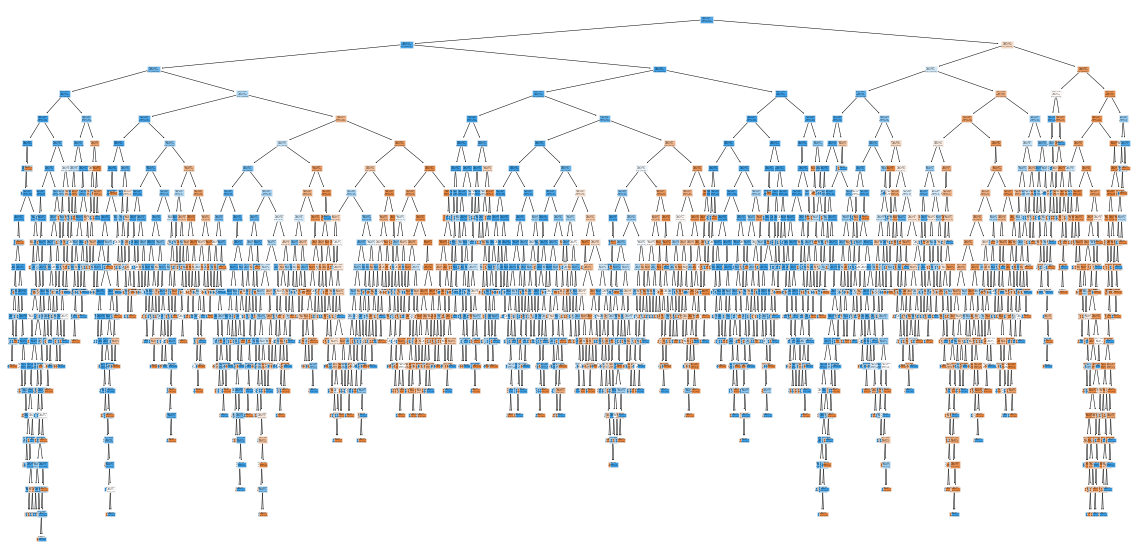

In [15]:
plt.figure(figsize=(20,10)) #definiendo el tamaño de la figura
plot_tree(tree,filled=True)
plt.show() #mostrando el árbol

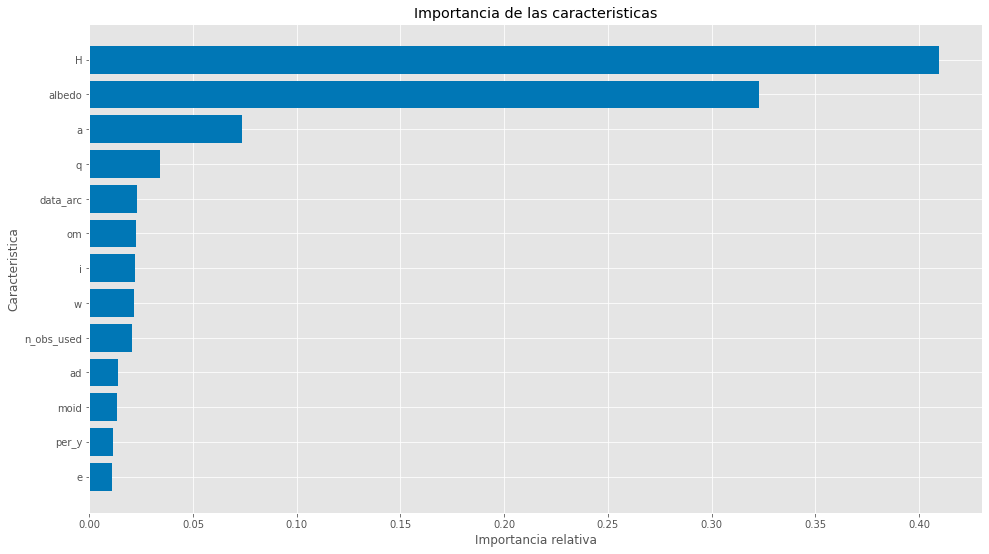

importancia de las variables:
 [0.0737622  0.01093989 0.02191689 0.02269328 0.02149659 0.03403349
 0.01402461 0.01124366 0.02316743 0.02067927 0.40981124 0.32295472
 0.01327672]


In [43]:
# Grafico de importancia de las caracteristicas

features = df_DataOrig_Sel2.columns
importances = tree.feature_importances_
indices = np.argsort(importances)

plt.title('Importancia de las caracteristicas')
plt.barh(range(len(indices)), importances[indices], color='#0077B6', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Importancia relativa')
plt.ylabel('Caracteristica')
plt.show()
print("importancia de las variables:\n",tree.feature_importances_)

In [44]:
tree = DecisionTreeClassifier(max_depth=3)

In [45]:
tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3)

In [46]:
test_score = tree.score(X_test, y_test)
print("Test Score", test_score)

Test Score 0.930630434105145


In [47]:
train_score = tree.score(X_train, y_train)
print("Train Score", train_score)

Train Score 0.9307433728836974


In [48]:
#Aplicando el modelo a otros datos
resultado=tree.predict(X_test)

In [49]:
#Generando la matriz de confusion
from sklearn.metrics import confusion_matrix
print("\n\nMatriz de confusión\n",confusion_matrix(y_test,resultado),"\n\n")



Matriz de confusión
 [[ 1099  1964]
 [  262 28764]] 




Confusion matrix, without normalization
[[ 1099  1964]
 [  262 28764]]
Normalized confusion matrix
[[0.35879856 0.64120144]
 [0.00902639 0.99097361]]


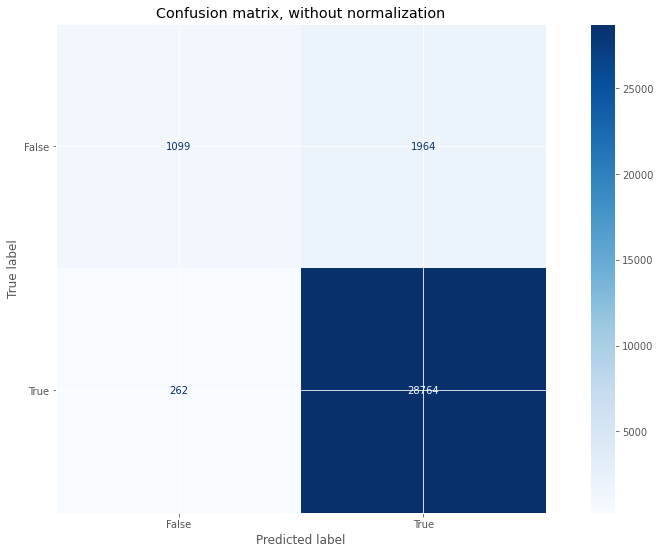

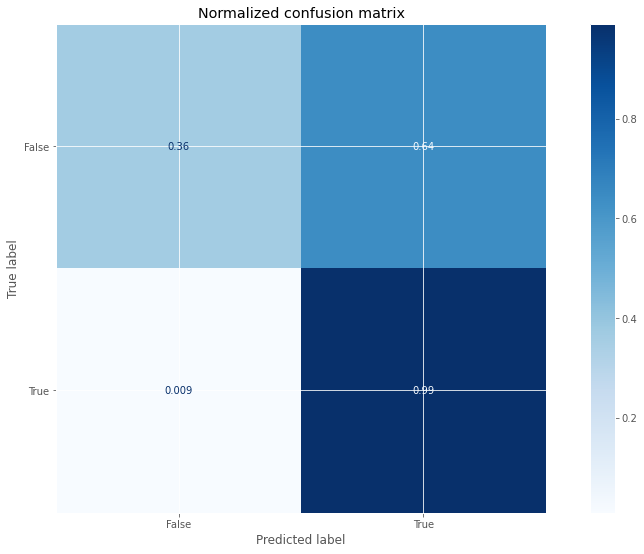

In [50]:
# Plot non-normalized confusion matrix

titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(tree, X_test, y_test,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

In [51]:
#Aplicando el modelo a otros datos
resultado=tree.predict_proba(X_test)
print("Resultado de la predicción:\n",resultado)

Resultado de la predicción:
 [[0.02958382 0.97041618]
 [0.00443544 0.99556456]
 [0.15356356 0.84643644]
 ...
 [0.07996261 0.92003739]
 [0.36784174 0.63215826]
 [0.00443544 0.99556456]]


In [52]:
# Se crean conjuntos k-fold para validacion cruzada
k = 10
kf = KFold(n_splits=k)

#errores
trainError=np.zeros(k)
testError=np.zeros(k)

finalModel_2 = DecisionTreeClassifier()
i=0
for train_index, test_index in kf.split(df_DataOrig_Sel2):
    finalModel_2 = finalModel_2.fit(df_DataOrig_Sel2.iloc[train_index,:-1],df_DataOrig_Sel2.iloc[train_index,-1])
    prediccion = finalModel_2.predict(df_DataOrig_Sel2.iloc[train_index,:-1])
    trainError[i] = mt.f1_score(df_DataOrig_Sel2.iloc[train_index,-1],prediccion,pos_label=1)
    prediccion = finalModel_2.predict(df_DataOrig_Sel2.iloc[test_index,:-1])
    testError[i] = mt.f1_score(df_DataOrig_Sel2.iloc[test_index,-1],prediccion,pos_label=1)
    i+=1

print("F1-score del modelo para training: ",trainError.mean(),"+-",trainError.std())
print("F1-score del modelo para test: ",testError.mean(),"+-",testError.std())
print("Profundidad: ",finalModel_2.get_depth())
print("Número de hojas: ",finalModel_2.get_n_leaves())

F1-score del modelo para training:  1.0 +- 0.0
F1-score del modelo para test:  0.9801981724331984 +- 0.000967790368964194
Profundidad:  25
Número de hojas:  1865


In [53]:
maximaProfundidad=22
resultados=pd.DataFrame(np.zeros((maximaProfundidad,5)),columns=["meanTrain","stdTrain","meanTest","stdTest","maxDepth"])
for i in range(maximaProfundidad):
    finalModel_2 = DecisionTreeClassifier(max_depth=i+1)
    trainError=np.zeros(k)
    testError=np.zeros(k)
    index=0
    for train_index, test_index in kf.split(df_DataOrig_Sel2):
        finalModel_2 = finalModel_2.fit(df_DataOrig_Sel2.iloc[train_index,:-1],df_DataOrig_Sel2.iloc[train_index,-1])
        prediccion = finalModel_2.predict(df_DataOrig_Sel2.iloc[train_index,:-1])
        trainError[index] = mt.f1_score(df_DataOrig_Sel2.iloc[train_index,-1],prediccion,pos_label=1)
        prediccion = finalModel_2.predict(df_DataOrig_Sel2.iloc[test_index,:-1])
        testError[index] = mt.f1_score(df_DataOrig_Sel2.iloc[test_index,-1],prediccion,pos_label=1)
        index+=1
    resultados.iloc[i,0]=trainError.mean()
    resultados.iloc[i,1]=trainError.std()
    resultados.iloc[i,2]=testError.mean()
    resultados.iloc[i,3]=testError.std()    
    resultados.iloc[i,4]=i+1

resultados

,meanTrain,stdTrain,meanTest,stdTest,maxDepth
0,0.954606,0.000180,0.954602,0.001616,1.0
1,0.959085,0.000582,0.958770,0.001530,2.0
2,0.960061,0.001367,0.959782,0.002475,3.0
3,0.976509,0.001605,0.976146,0.002642,4.0
4,0.978796,0.000406,0.978293,0.001118,5.0
5,0.984082,0.000190,0.983210,0.001005,6.0
6,0.986098,0.000265,0.984658,0.000720,7.0
7,0.987679,0.000187,0.984948,0.001155,8.0
8,0.989251,0.000172,0.984769,0.001048,9.0
9,0.990984,0.000187,0.984226,0.001318,10.0


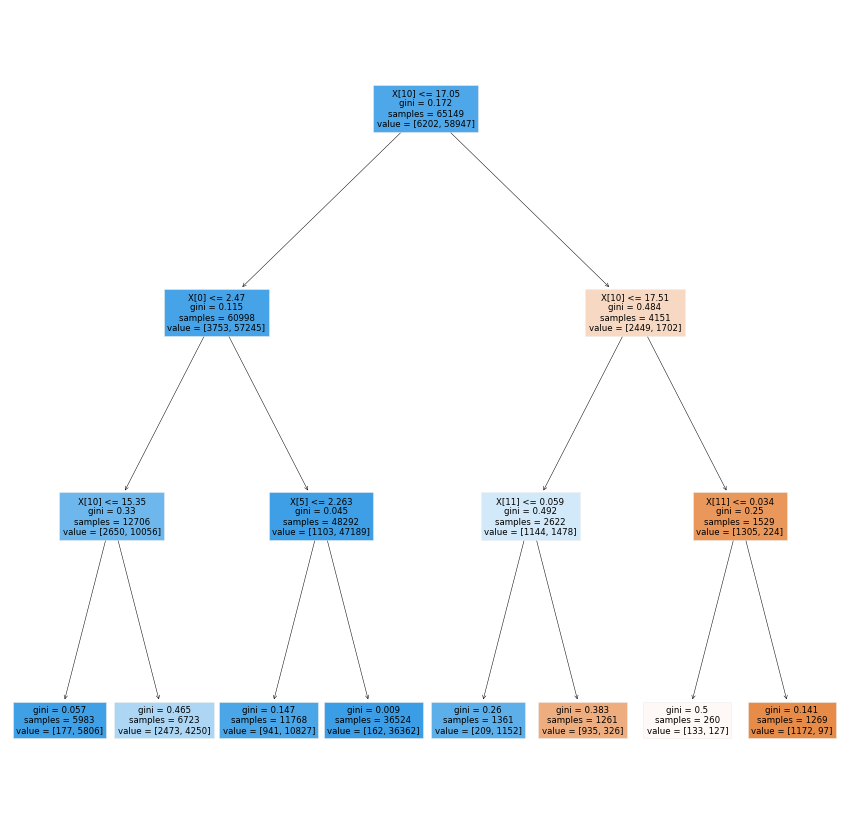

In [54]:
plt.figure(figsize=(15,15))
plot_tree(tree,filled=True)
plt.show()

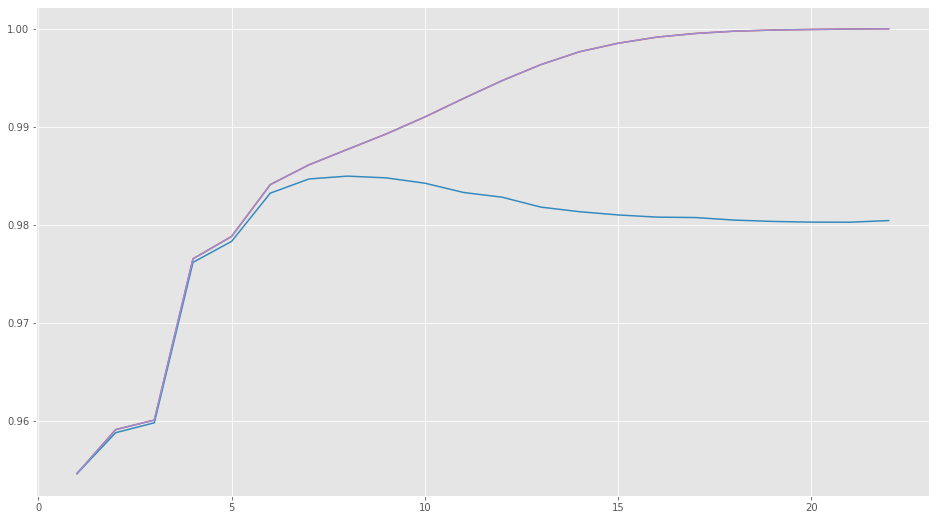

In [73]:
#Gráficar la profundidad y ver cuando se produce sobreentrenamiento

plt.plot(resultados.maxDepth, resultados.meanTrain)
plt.plot(resultados.maxDepth, resultados.meanTest)   # No dibuja datos de línea 1
plt.ion()   # Activa modo interactivo de dibujo
plt.plot(resultados.maxDepth, resultados.meanTrain)   # Dibuja datos de línea 2 sin borrar datos de línea 1

plt.show()

#El sobreentrenamiento en maxDepth empieza por encima de 5. Por eso se demuestra que la profundidad máxima debe ser en 5.